## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [2]:
import numpy as np
import pandas as pd

# Sentiment Analysis is the process of analyzing digital text to determine if the emotional tone of the message is positive, negative, or neutral
reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(d)** Test your sentiment-classifier on the test set.

**(e)** Use the classifier to classify a few sentences you write yourselves. 

0.5


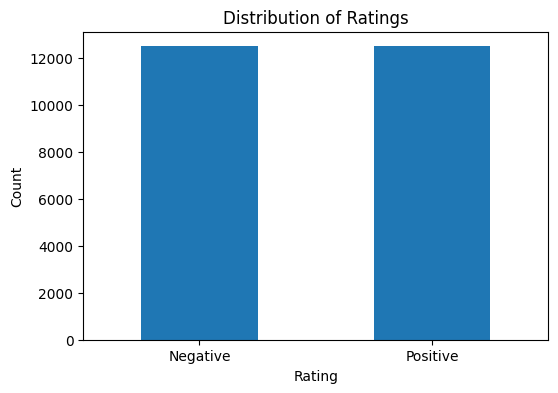

In [3]:
reviews, Y = reviews[0], Y[0]
Y = pd.Series(Y)  # convert to pandas Series
print(Y.mean())  # check if ratings are balanced (i.e. = 0.5)
import matplotlib.pyplot as plt

# plot the distribution of ratings
plt.figure(figsize=(6, 4))
Y.value_counts().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

In [4]:
# train - val - test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews, Y, test_size=0.15, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

# reset indices
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# dataset cardinalities (sizes)
# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
print(f"Train set: X: {X_train.shape} and Y: {y_train.shape}")
print(f"Validation set: X: {X_val.shape} and Y: {y_val.shape}")
print(f"Test set: X: {X_test.shape} and Y: {y_test.shape}")

Train set: X: (18062,) and Y: (18062,)
Validation set: X: (3188,) and Y: (3188,)
Test set: X: (3750,) and Y: (3750,)


# Bag-of-words

No sequential information, no information on importance of words in vocabulary, just frequency per text.

In [5]:
# bag-of-words (no sequential information, no information on importance of words, just frequency per text)
from sklearn.feature_extraction.text import CountVectorizer

# initialize with max 10k words
bow = CountVectorizer(max_features=10000)

# fit on entire body of text
X_train_bow = bow.fit_transform(X_train)
# transform into a document-term matrix
X_val_bow = bow.transform(X_val)
X_test_bow = bow.transform(X_test)

# get vocabulary, should be 10k size
vocab = bow.get_feature_names_out()
print("Vocabulary size:", len(vocab))

# let's look at a single sample, e.g. index 420
print("Raw text:", X_train[420]) # raw text
print("Word vector:", X_train_bow[420].toarray()[0], " - length:", len(X_train_bow[420].toarray()[0])) # word vector

# let's match word vector vocabulary and sort by count
word_counts = {vocab[i]:c for i, c in enumerate(X_train_bow[420].toarray()[0]) if c > 0}
word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

# let's see which words are the most important in this text?
print(word_counts)

Vocabulary size: 10000
Raw text: like some of the other reviewers have alluded to previously  i  d like to know what moron actually read the script and went    yea    this is it . this is the next film we are going to green light    and whoever that person is  should have his or her head examined for actual brain activity . because whoever is responsible for actually dishing out money to have this made after reading the script  well  i  d love to give you my email address and maybe you  d like to just give away some more money . this film is atrocious in every way .  br    br   the wayans are funny  at least they can be . they have made some good films and had some incredibly funny performances along the way . but in here  not only does the premise defy all logic  not only is the acting terrible  not only is the entire movie offensive from start to finish  not only is the direction as amateurish as you can find  but they actually want you to pay to see this film . maybe if it was free 

# TF-IDF

Term Frequency - Inverse Document Frequency.

$\text{TF-IDF}(t,d,D) = \text{TF}(t,d) \times \text{IDF}(t,D)$

Where:

$\text{TF}(t,d) = \frac{\text{count of term }t\text{ in document }d}{\text{total words in document }d}$

$\text{IDF}(t,D) = \log\left(\frac{N}{1 + |\{d \in D: t \in d\}|}\right)$

Where:
- t = term (word)
- d = document
- D = collection of all documents
- N = total number of documents in the corpus
- $|\{d \in D: t \in d\}|$ = number of documents containing term t
- The 1 + in denominator is added for smoothing to avoid division by zero

Final combined formula:

$\text{TF-IDF}(t,d,D) = \frac{\text{count of }t\text{ in }d}{\text{total words in }d} \times \log\left(\frac{N}{1 + |\{d \in D: t \in d\}|}\right)$

In [6]:
# tf-idf with n-grams and stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize with max 10k words
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),  # bigrams, unigrams, trigrams
    min_df=2,            # minimum document frequency (absolute value)
    max_df=0.9,          # maximum document frequency (as a fraction)
    stop_words='english' # get rid of "and", "to", "the", etc
)

# fit on entire body of text
X_train_tfidf = tfidf.fit_transform(X_train)
# transform into a document-term matrix
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# get vocabulary, should be 10k size
vocab = tfidf.get_feature_names_out()
print("Vocabulary size:", len(vocab))

# let's look at a single sample, e.g. index 420
print("Raw text:", X_train[420]) # raw text
print("Word vector:", X_train_tfidf[420].toarray()[0], " - length:", len(X_train_tfidf[420].toarray()[0])) # word vector

# It starts 
# Does not count unigram if it has been part of a bigram or trigram

# let's match word vector vocabulary and sort by tfidf score
word_scores = {vocab[i]:score for i, score in enumerate(X_train_tfidf[420].toarray()[0]) if score > 0}
word_scores = dict(sorted(word_scores.items(), key=lambda x: x[1], reverse=True))

# let's see which words are the most important in this text based on tf-idf scores
print(word_scores)

Vocabulary size: 10000
Raw text: like some of the other reviewers have alluded to previously  i  d like to know what moron actually read the script and went    yea    this is it . this is the next film we are going to green light    and whoever that person is  should have his or her head examined for actual brain activity . because whoever is responsible for actually dishing out money to have this made after reading the script  well  i  d love to give you my email address and maybe you  d like to just give away some more money . this film is atrocious in every way .  br    br   the wayans are funny  at least they can be . they have made some good films and had some incredibly funny performances along the way . but in here  not only does the premise defy all logic  not only is the acting terrible  not only is the entire movie offensive from start to finish  not only is the direction as amateurish as you can find  but they actually want you to pay to see this film . maybe if it was free 

2024-12-03 14:32:46.150849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 14:32:46.154976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 14:32:46.166740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733232766.183835  405004 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733232766.189129  405004 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 14:32:46.203901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Training Bag-of-Words model...


2024-12-03 14:32:47.894159: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-03 14:32:47.894193: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: BrambarPadT490
2024-12-03 14:32:47.894202: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: BrambarPadT490
2024-12-03 14:32:47.894313: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 470.256.2
2024-12-03 14:32:47.894342: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 470.256.2
2024-12-03 14:32:47.894352: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 470.256.2


Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7438 - loss: 0.5197 - val_accuracy: 0.8535 - val_loss: 0.3492
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9151 - loss: 0.2376 - val_accuracy: 0.8839 - val_loss: 0.2863
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9452 - loss: 0.1662 - val_accuracy: 0.8886 - val_loss: 0.2891
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9649 - loss: 0.1193 - val_accuracy: 0.8805 - val_loss: 0.3011
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9759 - loss: 0.0914 - val_accuracy: 0.8777 - val_loss: 0.3282

Training TF-IDF model...
Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7533 - loss: 0.6479 - val_accuracy: 0.8573 - val_loss: 0.4805
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8889 - loss: 0.4122 - val_accuracy: 0.8764 - val_loss: 0.3427
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9157 - loss: 0.2847 - val_ac

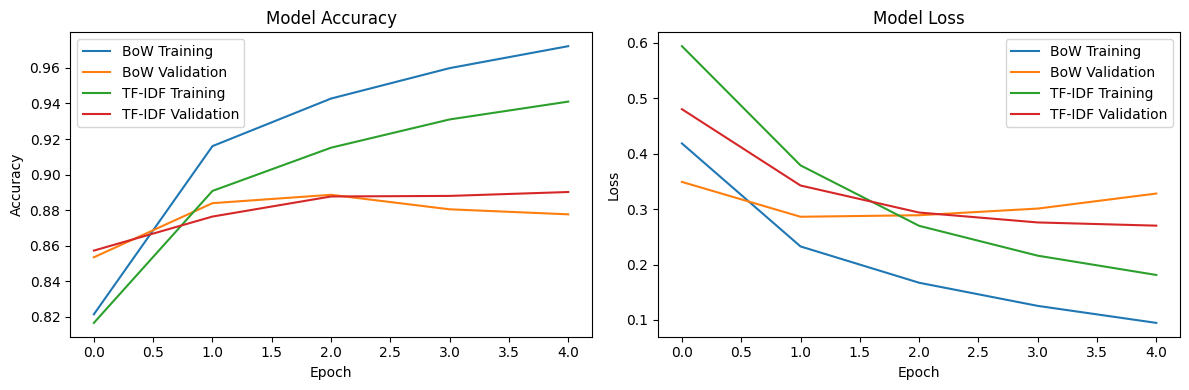

In [7]:
# train simple neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


# model parameters
input_dim = 10000 # from max_features in vectorizers
hidden_dim = 64   # parameters in layer 1
output_dim = 1    # parameters in layer 2, output layer, binary classification

# training parameters
epochs = 5
batch_size = 256

# function to create model (same architecture for both)
def create_model():
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(hidden_dim, activation='relu'), # recommended for hidden layers (generaly)
        Dropout(0.25),  # mitigate overfitting
        Dense(output_dim, activation='sigmoid') # recommended for binary classification
    ])
    model.compile(
        optimizer=AdamW(learning_rate=0.001), # frequently used optimizer learning rate
        loss='binary_crossentropy', # used for binary classification
        metrics=['accuracy']  # used to evaluate your model's performance
    )
    return model

# # wrap the model using KerasClassifier
# model = KerasClassifier(build_fn=create_model, verbose=0)

# # define the grid search parameters
# param_grid = {
#     'epochs': [5, 10, 15],
#     'batch_size': [64, 128, 256]
# }

# # create GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# # fit the grid search
# grid_result = grid.fit(X_train_bow.toarray(), y_train)

# # summarize results
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
# epochs = grid_result.best_params_['epochs']
# batch_size = grid_result.best_params_['batch_size']

# train BoW model
print("Training Bag-of-Words model...")
bow_model = create_model()
bow_history = bow_model.fit(
    X_train_bow.toarray(),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_bow, y_val),
    verbose=1
)

# train TF-IDF model
print("\nTraining TF-IDF model...")
tfidf_model = create_model()
tfidf_history = tfidf_model.fit(
    X_train_tfidf.toarray(),
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_tfidf, y_val),
    verbose=1
)

# compare final validation accuracies
print("\nFinal Results:")
print(f"BoW Model - Validation Accuracy: {bow_history.history['val_accuracy'][-1]:.4f}")
print(f"TF-IDF Model - Validation Accuracy: {tfidf_history.history['val_accuracy'][-1]:.4f}")

# optional: plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(bow_history.history['accuracy'], label='BoW Training')
plt.plot(bow_history.history['val_accuracy'], label='BoW Validation')
plt.plot(tfidf_history.history['accuracy'], label='TF-IDF Training')
plt.plot(tfidf_history.history['val_accuracy'], label='TF-IDF Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(bow_history.history['loss'], label='BoW Training')
plt.plot(bow_history.history['val_loss'], label='BoW Validation')
plt.plot(tfidf_history.history['loss'], label='TF-IDF Training')
plt.plot(tfidf_history.history['val_loss'], label='TF-IDF Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Very similar performance - why?

Hint:
- What are the identifiers of positive texts? Rare actor names or functional words and common adjectives?

## When would the added complexity be beneficial - and why?

Hint:
- More complex tasks - which?

<br>

<br>

<br>

<br>

<br>

## Could we make this even simpler?

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# naive bayes
nb = MultinomialNB()

# bow first
nb.fit(X_train_bow, y_train)
y_pred = nb.predict(X_val_bow)
print("BoW - NB - Accuracy:", accuracy_score(y_val, y_pred))

# tfidf
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print("TF-IDF - NB - Accuracy:", accuracy_score(y_val, y_pred))

BoW - NB - Accuracy: 0.8365746549560853
TF-IDF - NB - Accuracy: 0.8575909661229612


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Individual Model Accuracies:
BoW Model: 0.8777
TF-IDF Model: 0.8902
Ensemble Model: 0.8890

Ensemble Detailed Performance:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1567
           1       0.89      0.89      0.89      1621

    accuracy                           0.89      3188
   macro avg       0.89      0.89      0.89      3188
weighted avg       0.89      0.89      0.89      3188



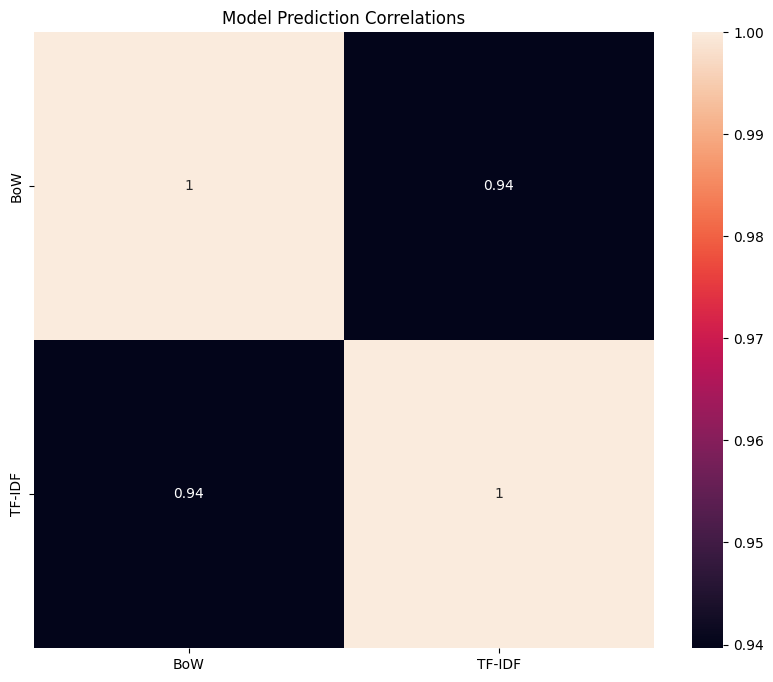

In [9]:
# get predictions (probabilities) from all models
bow_pred = bow_model.predict(X_val_bow.toarray())
tfidf_pred = tfidf_model.predict(X_val_tfidf.toarray())

# soft voting (average probabilities)
ensemble_pred_proba = (bow_pred + tfidf_pred) / 2
ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)

# calculate metrics
from sklearn.metrics import accuracy_score, classification_report

print("\nIndividual Model Accuracies:")
print(f"BoW Model: {accuracy_score(y_val, (bow_pred > 0.5).astype(int)):.4f}")
print(f"TF-IDF Model: {accuracy_score(y_val, (tfidf_pred > 0.5).astype(int)):.4f}")

print(f"Ensemble Model: {accuracy_score(y_val, ensemble_pred):.4f}")

print("\nEnsemble Detailed Performance:")
print(classification_report(y_val, ensemble_pred))

# visualize model agreement
import seaborn as sns
import matplotlib.pyplot as plt

predictions = np.hstack([bow_pred, tfidf_pred])
correlation_matrix = np.corrcoef(predictions.T)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            xticklabels=['BoW', 'TF-IDF'],
            yticklabels=['BoW', 'TF-IDF'])
plt.title('Model Prediction Correlations')
plt.show()

In [ ]:
# Custom sentences
custom_sentences = [
    "I absolutely loved this movie! The plot was amazing and the acting was superb.",
    "This was the worst film I have ever seen. Completely boring and a waste of time.",
    "It was an okay movie, not great but not terrible either.",
    "The storyline was very predictable and the characters were not interesting.",
    "An excellent film with a lot of heart and great performances.",
    "This moved me into tears",
    "Box Box Box, We retire the car",
    "What a pleasent rainy afternoon",
    "What a night",
    "Merry Christmas"
]

# "Merry Christmas" is predicted to be negative from both of the models, because the sentances in which it has been part of have been negative overall.

# Preprocess the custom sentences using the same vectorizers
custom_sentences_bow = bow.transform(custom_sentences)
custom_sentences_tfidf = tfidf.transform(custom_sentences)

# Predict sentiment using the trained models
bow_custom_pred = bow_model.predict(custom_sentences_bow.toarray())
tfidf_custom_pred = tfidf_model.predict(custom_sentences_tfidf.toarray())

# Average the predictions for ensemble
ensemble_custom_pred_proba = (bow_custom_pred + tfidf_custom_pred) / 2
ensemble_custom_pred = (ensemble_custom_pred_proba > 0.5).astype(int)

# Print the results
for i, sentence in enumerate(custom_sentences):
    print(f"Sentence: {sentence}")
    print(f"BoW Prediction: {'Positive' if bow_custom_pred[i] > 0.5 else 'Negative'}")
    print(f"TF-IDF Prediction: {'Positive' if tfidf_custom_pred[i] > 0.5 else 'Negative'}")
    print(f"Ensemble Prediction: {'Positive' if ensemble_custom_pred[i] == 1 else 'Negative'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sentence: I absolutely loved this movie! The plot was amazing and the acting was superb.
BoW Prediction: Positive
TF-IDF Prediction: Positive
Ensemble Prediction: Positive
Sentence: This was the worst film I have ever seen. Completely boring and a waste of time.
BoW Prediction: Negative
TF-IDF Prediction: Negative
Ensemble Prediction: Negative
Sentence: It was an okay movie, not great but not terrible either.
BoW Prediction: Negative
TF-IDF Prediction: Negative
Ensemble Prediction: Negative
Sentence: The storyline was very predictable and the characters were not interesting.
BoW Prediction: Negative
TF-IDF Prediction: Negative
Ensemble Prediction: Negative
Sentence: An excellent film with a lot of heart and great performances.
BoW Prediction: Positive
TF-IDF Prediction: Positive
Ensemble Prediction: Positive
Sentence: This moved me into tears
BoW Prediction: Positive
TF-IDF Prediction: Positive
Ensemble Predict